## Problema de Negócio

Na última etapa do nosso projeto, estamos agora na construção do modelo preditivo para saber a probabilidade de um cliente assinar o termo de depósito bancário à prazo. Para retomar todas as etapas.

* 1º Construção de uma análise de regressão para compreender como as variáveis influenciam, probabilisticamente, na decisão de assinar o termo de depósito bancário à prazo. Isso permite que os tomadores de decisões entenda quais variáveis interferir e ajustar.
* 2º Análise de agrupamentos para entender os principais perfis naturais para um melhor direcionamento de campanhas e abordagens mais efetivas pelos tomadores de decisões.

## 0.0 Pacotes e Bibliotecas

In [84]:
# Manipulação de Dados
import pandas as pd
import numpy as np

# Visualização dos Dados
import seaborn
from matplotlib import pyplot as plt

# Pipeline
from sklearn import pipeline

# Pré-Processamento
from sklearn import compose, preprocessing

# Construção de teste, treino e validação
from sklearn import model_selection, tree, neighbors, naive_bayes

# Algoritmos de aprendizado de máquina
from sklearn import linear_model

# Métricas de avaliação
from sklearn import metrics
import scikitplot as scktplt

# Calibração das probabilidades
from sklearn import calibration

# Salvar modelos
import pickle as pkl

### 0.1 Funções Auxiliares

In [43]:
def metricas_avaliacao(y_real, y_predito, y_predito_probabilidade):

    # Acurácia
    acuracia = metrics.accuracy_score(y_real, y_predito)

    # Precisao
    precisao = metrics.precision_score(y_real, y_predito)

    # Recuperação
    recuperacao = metrics.recall_score(y_real, y_predito)

    # Auc
    auc = metrics.roc_auc_score(y_real, y_predito_probabilidade[:, 1])


    print('=============== Métricas Avaliação ==================')

    print(f'Acuracia: {np.round(acuracia*100, 2)}%.')
    print(f'Precisão: {np.round(precisao*100, 2)}%.')
    print(f'Recuperação: {np.round(recuperacao*100, 2)}%.')
    print(f'Auc: {np.round(auc*100, 2)}%.')

    print('===================== Matriz de Confusão =======================')
    
    # Configuração da plotagem
    fig, graficos = plt.subplots(1, 4, figsize=(25,5)) 

    # Matriz de Confusão
    matriz_confusao = metrics.confusion_matrix(y_real, y_predito)
    matriz_confusao_grafico = metrics.ConfusionMatrixDisplay(confusion_matrix=matriz_confusao)
    matriz_confusao_grafico.plot(ax=graficos[0])

    # Curva de lift
    curva_lift = scktplt.metrics.plot_lift_curve(y_real, y_predito_probabilidade, ax=graficos[1])

    # Curva de ganho
    curva_ganho = scktplt.metrics.plot_cumulative_gain(y_real, y_predito_probabilidade, ax=graficos[2])

    # Curva Roc
    curva_roc = scktplt.metrics.plot_roc(y_real, y_predito_probabilidade, ax=graficos[3])

    return acuracia, precisao, recuperacao, auc

## 1.0 Carregamento dos Dados

In [44]:
# Carregamento dos Dados
df1 = pd.read_csv('../BaseDados/bank-full.csv', delimiter=';', low_memory=False)

# Validação dos Dados
print(f'Qtd. Linhas: {df1.shape[0]}; Qtd. Colunas {df1.shape[1]}')

# Amostra dos Dados
df1.head(5)

Qtd. Linhas: 45211; Qtd. Colunas 17


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


### 1.1 Dicionário de Dados

Logo abaixo, temos o dicionário das variáveis.

| Nome da Variável | Descrição |
|------------------|-------------------|
|     age       |   Idade do Cliente| 
|     job       | 	Tipo do trabalho. Temos as seguintes categorias: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown'.|
|    marital    |   Status Matrimonia. Categorias: 'divorced','married','single','unknown'. |
|   education   |   Nível educacional do cliente. Categorias: 'primary', 'secondary', 'tertiary' |
|    default    |   Essa variável nos diz se o cliente é inadimplente. Categorias: 'yes', 'no'. |
|    balance    |   Saldo médio anual do cliente na conta, cuja unidade é em euros. |
|    housing    |   Possui financiamento imobiliário? Categorias: 'yes', 'no'.|
|    loan       |   Possui empréstimo pessoal? Categorias: 'yes', 'no'. |
|    contact    |   Meio de contato utilizado para falar com o cliente. Categorias: 'celular', 'telephone'.|
|  day_of_week  |   Último Dia da semana em que o contato foi feito. |
|     month     |   Último mês de contato com o cliente. |
|   duration    |   Duração da ligação, em segundos, da última ligação. |
|   campaign    |   Número de contatos realizados com o cliente durante a campanha atual. |
|    pdays      |   Número de dias que se passaram desde o último contato com o cliente em uma campanha anterior. Se a variável -1, então o cliente não foi contatado. |
|   previous    |   Número de contatos realizados com o clientes antes dessa campanha. |
|   poutcome    |   Resultado da campanha anterior de marketing. |
|      y        |   Variável alvo para saber se o cliente assinou ou não termo de depósito. Categorias: 'yes':Aceitou; 'no': Não Aceitou |

## 2.0 Análise Exploratória dos Dados

Na nossa análise exploratória, para além de compreender as variáveis, é entender também se os dados são consistentes, isto é, a história que os dados contam, faz sentido? 
Isso é extremamente importante, pois trabalhar com dados errados e inconsistentes impacta em um produto final inútil.

In [45]:
# Cópia dos Dados
df2 = df1.copy()

# Validação
print(f'Qtd. Linhas: {df2.shape[0]}; Qtd. Colunas: {df2.shape[1]}.')

# Amostra
df2.sample(3)

Qtd. Linhas: 45211; Qtd. Colunas: 17.


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
20444,35,management,married,tertiary,no,100,no,no,cellular,12,aug,120,2,-1,0,unknown,no
33555,35,technician,single,secondary,no,353,yes,no,cellular,20,apr,8,3,-1,0,unknown,no
28496,30,services,single,secondary,no,1923,no,yes,cellular,29,jan,114,2,192,2,other,no


### 2.1 Variável Alvo

Vamos analisar nossa variável alvo para entender como está a distribuição.

In [46]:
df2['y'].value_counts()

y
no     39922
yes     5289
Name: count, dtype: int64

Como estamos com um base de dados desbalanceada, vamos precisar balancear os dados. Nesse caso, basta obtermos uma amostra dos dados da classe 'no' com a mesma volumetria da classe 'yes'.

### 2.2 Tipagem dos Dados

In [47]:
# Tipo dos dados
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


Vamos precisar renomear a variável 'y'.

### 2.3 Análise Exploratória dos Dados

**Variáveis Numéricas**

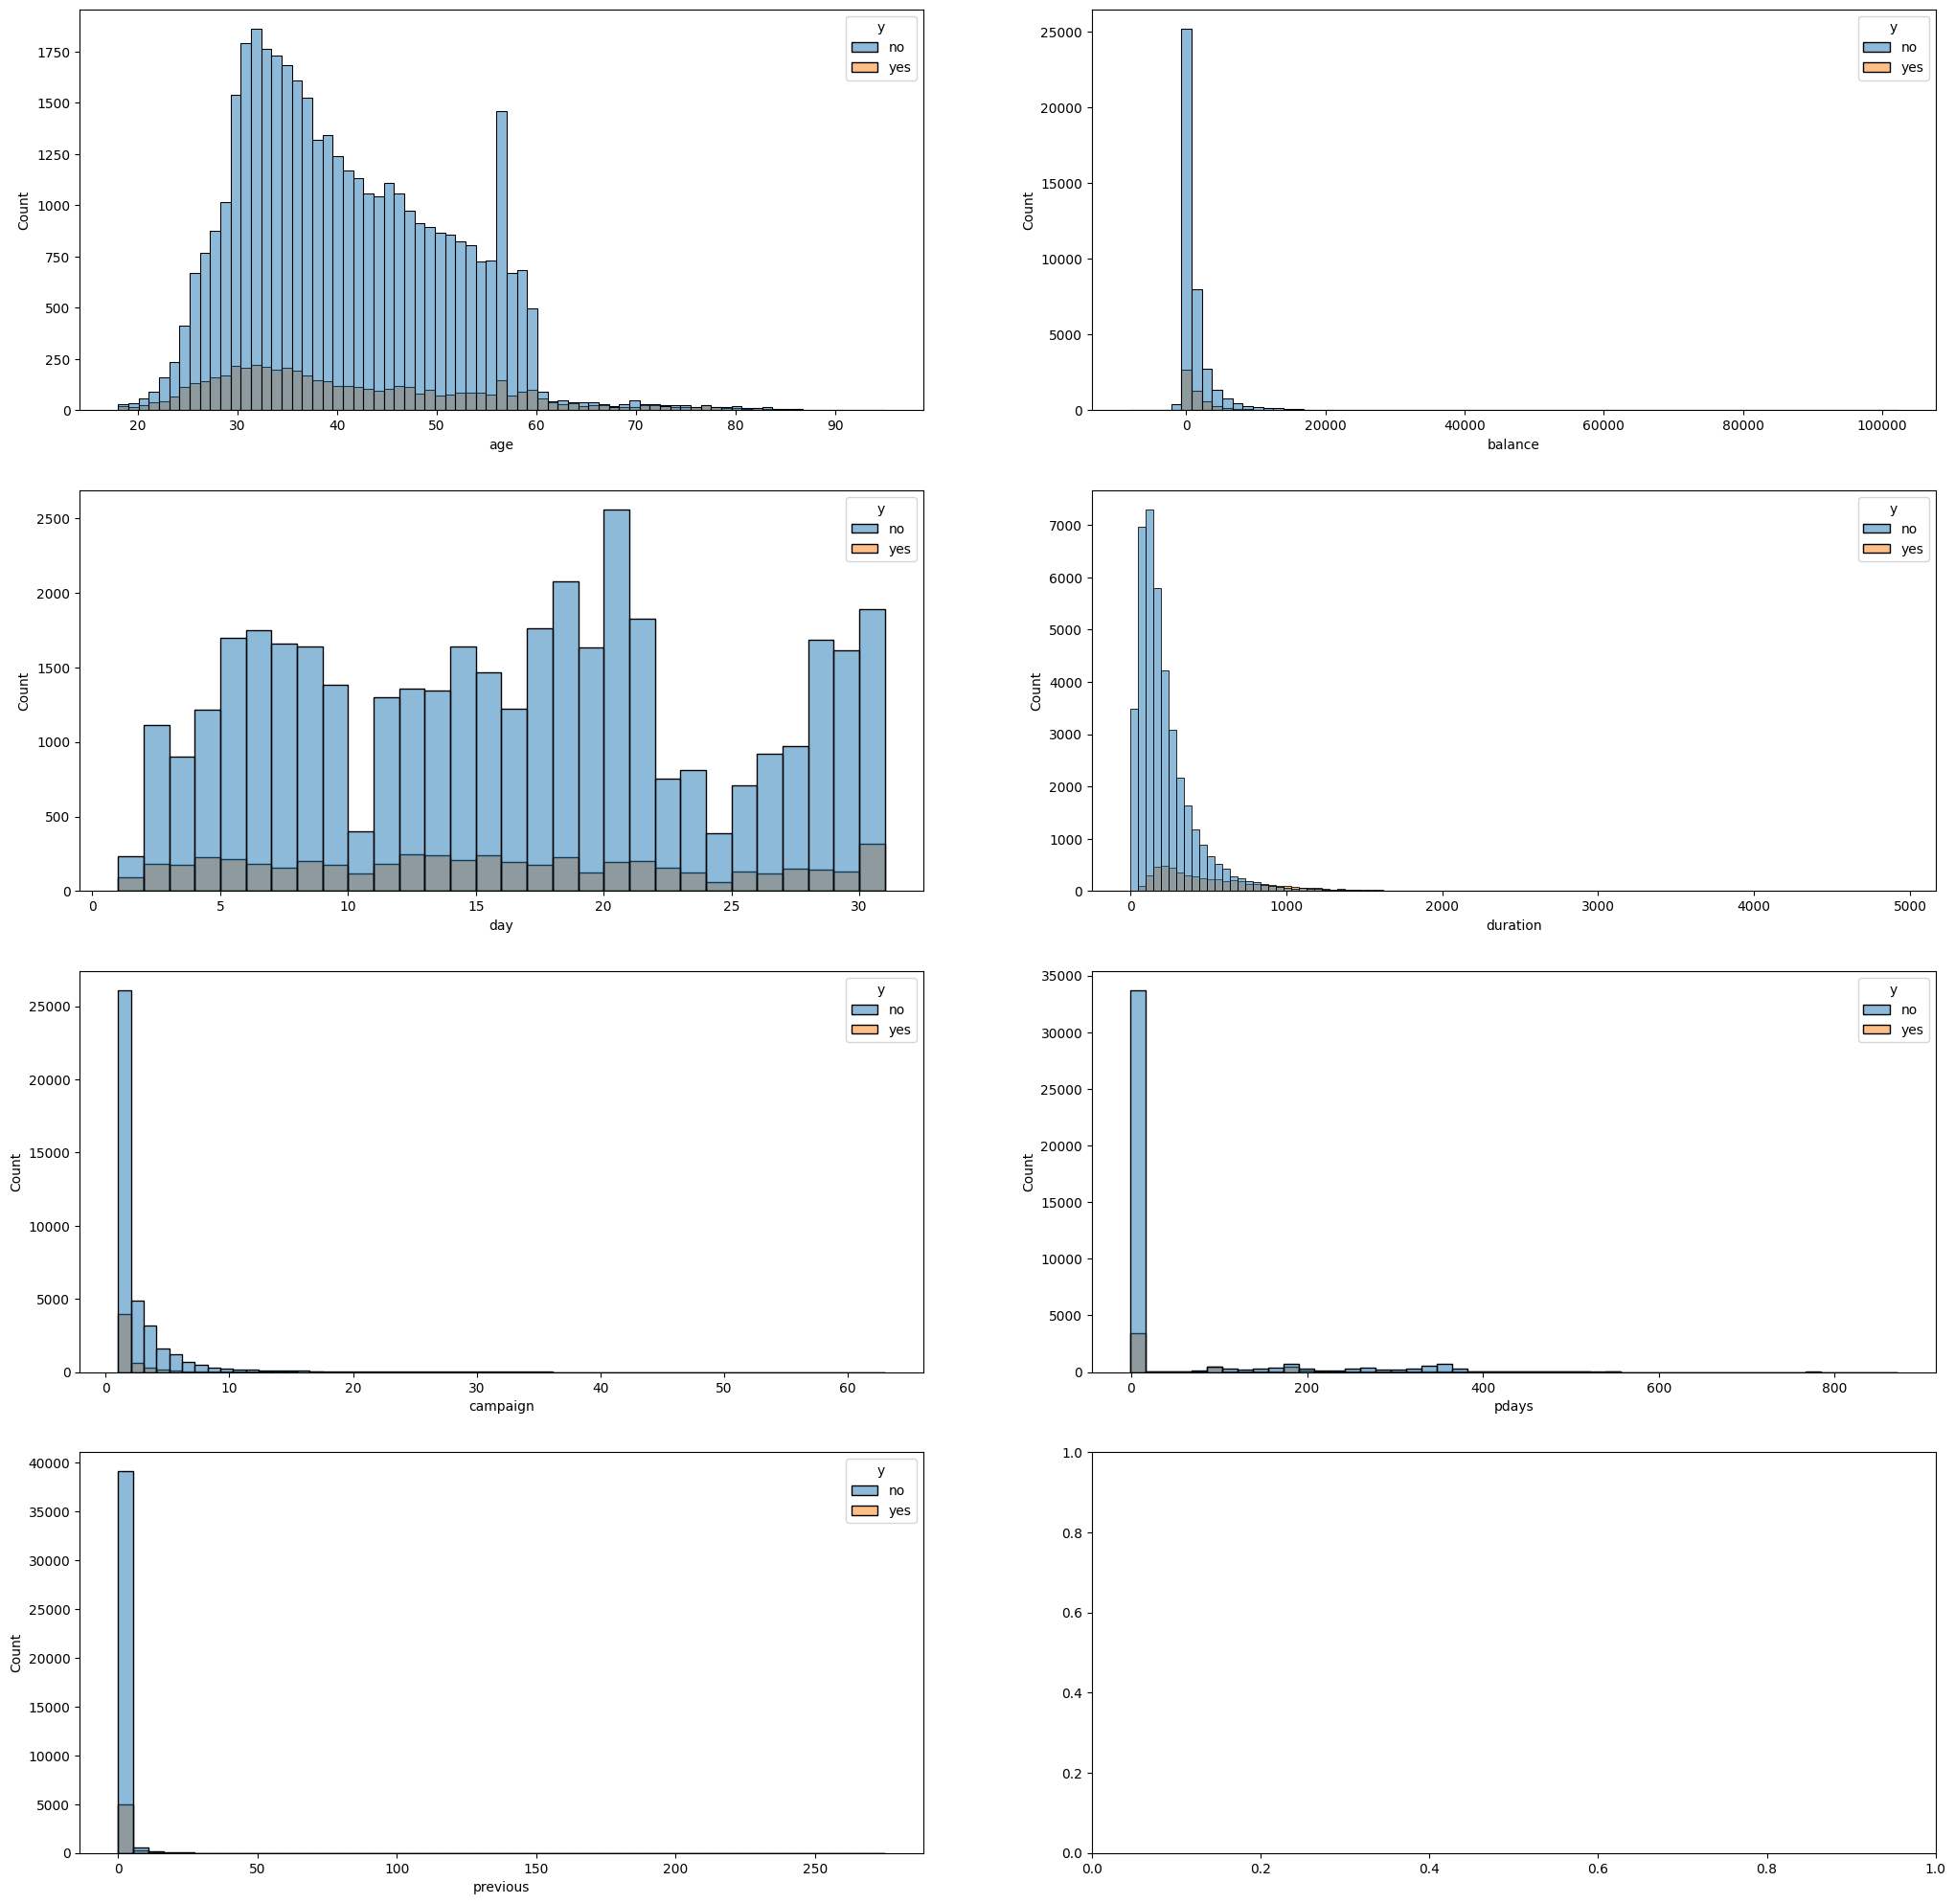

In [48]:
# Difinindo a figura
eda_varnum_fig, ax = plt.subplots(4, 2, figsize=(25,25));

# Distibuição da variável age
seaborn.histplot(data=df2, x='age', hue='y', bins=75, ax=ax[0][0]);
seaborn.histplot(data=df2, x='balance', hue='y', bins=75, ax=ax[0][1]);
seaborn.histplot(data=df2, x='day', hue='y', bins=30, ax=ax[1][0]);
seaborn.histplot(data=df2, x='duration', hue='y', bins=100, ax=ax[1][1]);
seaborn.histplot(data=df2, x='campaign', hue='y', bins=60, ax=ax[2][0]);
seaborn.histplot(data=df2, x='pdays', hue='y', bins=50, ax=ax[2][1]);
seaborn.histplot(data=df2, x='previous', hue='y', bins=50, ax=ax[3][0]);

**Variáveis Categóricas**

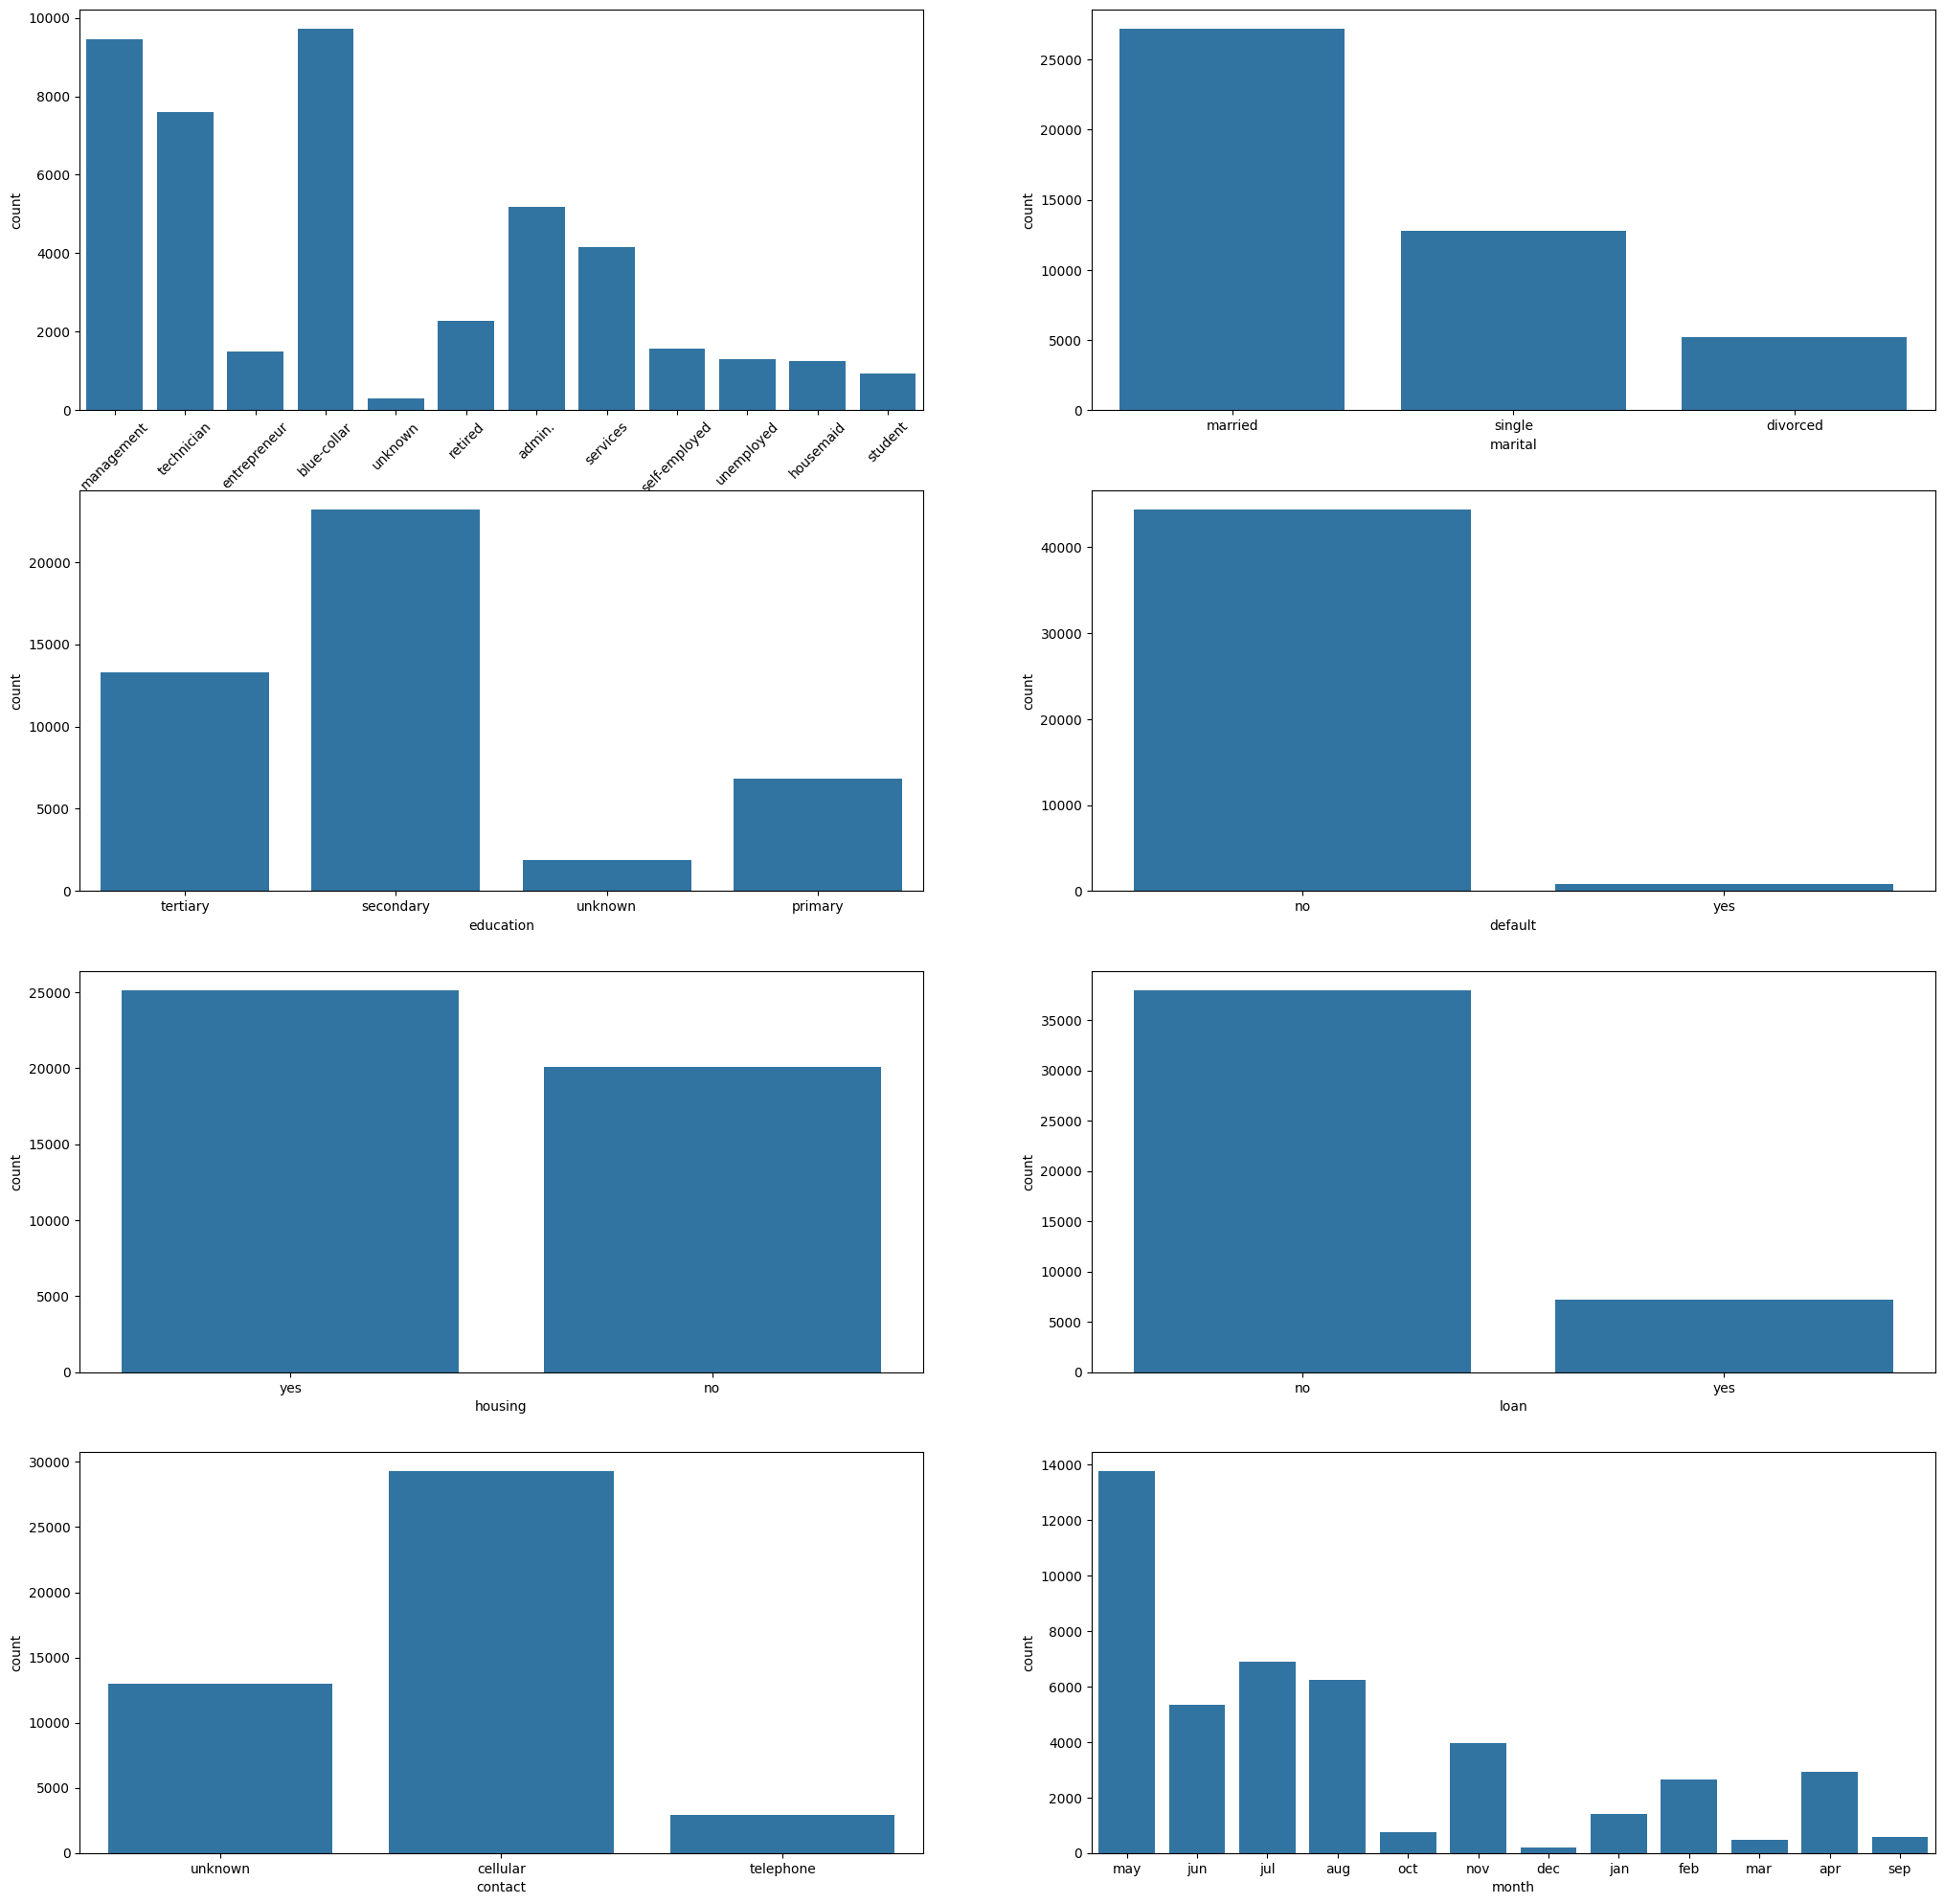

In [49]:
# Definindo a área de plotagem
fig_varcat_eda, bx = plt.subplots(4, 2, figsize=(25, 25));

# Gráficos
seaborn.countplot(data=df2, x='job', ax=bx[0][0]);
bx[0][0].tick_params(axis='x', rotation=45);

seaborn.countplot(data=df2, x='marital', ax=bx[0][1]);
seaborn.countplot(data=df2, x='education', ax=bx[1][0]);
seaborn.countplot(data=df2, x='default', ax=bx[1][1]);
seaborn.countplot(data=df2, x='housing', ax=bx[2][0]);
seaborn.countplot(data=df2, x='loan', ax=bx[2][1]);
seaborn.countplot(data=df2, x='contact', ax=bx[3][0]);
seaborn.countplot(data=df2, x='month', ax=bx[3][1]);

**Relatório Final**

* age: Na variável idade, possuímos um comportamento esperado. Os clientes estão bem concentrados entre as faixas de 30 a 60 anos, que é o período mais ativo, em termos financeiros, de uma pessoa. Logo, os dados estão consistentes.
* balance: Temos uma concentração de saldo médio em até 20.000. Totalmente esperado, pois são poucos clientes que terão muito dinheiro.
* day: inconclusivo
* duration: NO meio telefônico, é totalmente esperado muitas ligações com pouco tempo de duração e, poucas ligações com um longo tempo de duração. Comportamento esperado.
* campaing: Raciocício análogo a variável duration.
* pdays: Temos nessa base clientes que foram contatados a primeira vez, claramente, uma parte da base é prospecção. E a outra parte segue o raciocínio a variável duration.
* previous: idem variável duration.
* marital: Com essa podemos ver que os clientes são majoritariamente casados, seguidos de solteiros. 
* education: Os clientes do banco possuem, em sua maioria, o segundo grau completo. Isso também está dentro do esperado.
* default: Não há nem o que dizer nessa variável. Faz total sentido que os clientes de um banco sejam majoritariamente não-inadimplentes, caso contrário, o banco quebraria.
* housing: Aqui temos um comportamento interessante, da nossa lista, a maioria dos clientes possuem financiamentos imobiliários. Um dos principais motivos foi a desvalorização de imóveis por conta da explosão da bolha imobiliária de 2008 e, o incentivo ao crédito imobiliário.
* loan: Poucos clientes possuem um empréstimo pessoal. Faz sentido, não são todos que vão tomar crédito.
* contact: A maioria dos contatos realizados são por celular, o que faz bastante sentido, pois é muito mais fácil encontrar o cliente no telefone pessoal do que em um telefone fixo.
* month: inconclusivo.

Resumidamente, temos um dataset consistente. Podemos seguir nossa análise.

### 2.3 Resumo Estatístico

**Variáveis Numéricas**

In [50]:
df2.select_dtypes(include=['int64', 'float64']).describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


**Variáveis Categóricas**

In [51]:
df2.select_dtypes(exclude=['int64', 'float64']).describe()

,job,marital,education,default,housing,loan,contact,month,poutcome,y
count,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211
unique,12,3,4,2,2,2,3,12,4,2
top,blue-collar,married,secondary,no,yes,no,cellular,may,unknown,no
freq,9732,27214,23202,44396,25130,37967,29285,13766,36959,39922


Ao analisar o nosso resumo estatístico, temos as seguintes conclusõe:
* A variável balance possui outliers, o que é esperado, pois em instituições bancárias, existem clientes que terão um saldo médio extremamente elevado.
* O comportamento da variável duration também é esperado. Lembrando que o dataset com o qual estamos trabalhando é de meados de 2008-2010, é esperado que tenhamos ligações mais duradouras, como por exemplo, de 1 hora e 30 minutos.
* Esse número, 63, que é um outliers na variável campaign, pode ser extremamente factível. Observe que, em uma época em que era necessário entrar em contato com o gerente e central para realizar transações, um  63 contatos em uma campanha, poderia ser feito tranquilamente por um cliente que é dono de uma empresa. O que torna mais factível isso que comentamos é o fato de a segunda maior volumetria de clientes ser empresários.
* Na variável pdays, é possível um cliente não ser contatado a mais de 875 dias. Às vezes é um cliente que está inativo.
* Um cliente bem relacionado pode tranquilamente poderia realizar 275 contatos antes da campanha. Novamente, coloquemos um cliente que é dono de uma empresa e que realiza muitas transações.  

Podemos observar que não foi notado nada atípico em nosso dataset. Vamos seguir com a análise exploratória dos dados para verificar a consistência dos dados.

**Tratativas Necessárias**

Da nossa análise exploratória, precisamos realizar algumas tratativas. 
1. Não temos a necessidade de tratar dados nulos.
2. Em nossa análise, os outliers que estão presentes nas variáveis contínuas são totalmente esperados. Logo, tratamento de remoção de outliers não é algo a ser considerado.
3. Na variável pdays, vamos realizar uma engenharia de atributos para detectar os clientes que são novos ou não, isto é, vamos categorizar essa variável.
4. Vamos selecionar os clientes em que as ligações duram, pelo menos, mais de 30 segundos. Dado o contexto do nosso problema de negócio, que é a probabilidade de um cliente aceitar oo depósito bancário por meio de ligações telefônicas, é viável considerar que clientes que, em certa medida, são ativos em ligações, isto é, possuem tempo da última ligação de, pelo menos 30 segundos.
5. Eliminaremos as colunas day e month.

## 3.0 Tratamentos dos Dados

Nessa etapa, vamos realizar os tratamentos dos dados para que possamos iniciar a fase de construção dos pipelines.


In [52]:
# Cópia dos Dados
df3 = df2.copy()

# Validação dos Dados
print(f'Qtd. Linhas: {df3.shape[0]}; Qtd. Colunas: {df3.shape[1]}.')

# Amostra dos Dados
df3.sample(5)

Qtd. Linhas: 45211; Qtd. Colunas: 17.


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
42958,36,technician,single,secondary,no,27,yes,no,cellular,9,feb,631,1,260,2,success,yes
13253,44,management,married,tertiary,no,0,no,no,cellular,8,jul,54,2,-1,0,unknown,no
10206,42,blue-collar,married,unknown,no,8600,no,no,unknown,11,jun,90,9,-1,0,unknown,no
24196,37,technician,married,secondary,no,421,yes,yes,cellular,17,nov,85,1,-1,0,unknown,no
34584,33,services,married,secondary,no,255,yes,yes,cellular,5,may,237,4,165,4,failure,no


### 3.1 Eliminando as Colunas Desnecessárias

In [53]:
# Eliminando as colunas desnecessárias
df3 = df3.drop(columns=['day', 'month'], axis=1).copy()

# Validação dos Dados
print(f'Qtd. Linhas: {df3.shape[0]}; Qtd. Colunas: {df3.shape[1]}.')

# Amostra dos Dados
df3.sample(3)

Qtd. Linhas: 45211; Qtd. Colunas: 15.


,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,y
14125,44,services,married,secondary,yes,-146,yes,no,cellular,256,2,-1,0,unknown,no
36671,34,blue-collar,married,secondary,no,-53,yes,no,cellular,196,2,357,1,failure,no
17175,42,blue-collar,married,secondary,no,-128,no,yes,cellular,180,4,-1,0,unknown,no


In [54]:
df3['poutcome'].value_counts()

poutcome
unknown    36959
failure     4901
other       1840
success     1511
Name: count, dtype: int64

In [55]:
# Tratamento da Variável Job
df3['job'] = np.where(df3['job'] == 'unknown', 'unknown_job', df3['job'])

# Tratamento da Variável Education
df3['education'] = np.where(df3['job'] == 'unknown', 'unknown_education', df3['education'])

# Tratamento da Variável Contact
df3['contact'] = np.where(df3['contact'] == 'unknown', 'unknown_contact', df3['contact'])

# Tratamento da Variável poutcome
df3['poutcome'] = np.where(df3['poutcome'] == 'unknown', 'unknown_outcome', df3['poutcome'])

# Renomeando a coluna de variável de aceitação de contrato
df3 = df3.rename(columns={'y':'accepted_contract'}).copy()

# Validação dos Dados
print(f'Qtd. Linhas: {df3.shape[0]}; Qtd. Colunas: {df3.shape[1]}.')

# Amostra dos Dados
df3.sample(10)

Qtd. Linhas: 45211; Qtd. Colunas: 15.


,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,accepted_contract
14100,58,retired,married,secondary,no,100,yes,no,cellular,186,2,-1,0,unknown_outcome,no
32847,35,services,married,secondary,no,1728,yes,no,cellular,865,1,-1,0,unknown_outcome,no
19437,44,technician,married,secondary,no,339,yes,yes,telephone,244,3,-1,0,unknown_outcome,no
38235,43,services,married,secondary,no,-1,yes,no,cellular,51,1,311,2,failure,no
4152,28,student,single,tertiary,no,836,yes,no,unknown_contact,36,1,-1,0,unknown_outcome,no
17237,39,services,divorced,secondary,no,293,yes,yes,telephone,148,2,-1,0,unknown_outcome,no
34734,46,management,married,tertiary,no,523,yes,no,cellular,105,4,366,2,failure,no
7033,28,admin.,single,secondary,no,1238,yes,no,unknown_contact,252,2,-1,0,unknown_outcome,no
8067,29,technician,married,secondary,no,493,yes,yes,unknown_contact,132,6,-1,0,unknown_outcome,no
40780,44,management,divorced,tertiary,no,0,no,no,cellular,71,1,-1,0,unknown_outcome,no


### 3.2 Seleção dos Dados

In [56]:
# Obtendo os dados dos clientes cuja duração de ligações são mais que 30 segundos.
df3 = df3[df3['duration'] >= 30].copy()

# Validação dos Dados
print(f'Qtd. Linhas: {df3.shape[0]}; Qtd. Colunas: {df3.shape[1]}.')

# Amostra dos Dados
df3.head(5)

Qtd. Linhas: 43264; Qtd. Colunas: 15.


,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,accepted_contract
0,58,management,married,tertiary,no,2143,yes,no,unknown_contact,261,1,-1,0,unknown_outcome,no
1,44,technician,single,secondary,no,29,yes,no,unknown_contact,151,1,-1,0,unknown_outcome,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown_contact,76,1,-1,0,unknown_outcome,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown_contact,92,1,-1,0,unknown_outcome,no
4,33,unknown_job,single,unknown,no,1,no,no,unknown_contact,198,1,-1,0,unknown_outcome,no


### 3.3 Ajuste da Variável Alvo

In [57]:
df3['accepted_contract'] = df3['accepted_contract'].apply(lambda x: 1 if x=='yes' else 0)

df3.head()

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,accepted_contract
0,58,management,married,tertiary,no,2143,yes,no,unknown_contact,261,1,-1,0,unknown_outcome,0
1,44,technician,single,secondary,no,29,yes,no,unknown_contact,151,1,-1,0,unknown_outcome,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown_contact,76,1,-1,0,unknown_outcome,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown_contact,92,1,-1,0,unknown_outcome,0
4,33,unknown_job,single,unknown,no,1,no,no,unknown_contact,198,1,-1,0,unknown_outcome,0


## 4.0 Engenharia de Atributos

Nessa etapa, vamos realizar ajustes na variável pdays.

In [58]:
# Cópia dos Dados
df4 = df3.copy()

# Validação dos Dados
print(f'Qtd. Linhas {df4.shape[0]}; Qtd. Colunas: {df4.shape[1]}.')

# Amostra dos Dados
df4.sample(5)

Qtd. Linhas 43264; Qtd. Colunas: 15.


,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,accepted_contract
41351,36,unemployed,single,tertiary,no,953,yes,no,cellular,102,2,101,3,failure,0
27246,32,blue-collar,single,primary,no,3595,yes,no,cellular,171,2,-1,0,unknown_outcome,0
28319,38,management,divorced,tertiary,no,1927,yes,yes,cellular,527,1,-1,0,unknown_outcome,0
20275,58,management,married,tertiary,no,889,no,no,cellular,121,2,-1,0,unknown_outcome,0
30463,28,management,single,tertiary,no,810,yes,no,cellular,137,2,-1,0,unknown_outcome,0


In [59]:
# Engenharia da variável pdays
df4['pdays'] = np.where(df4['pdays'] == -1, 'First Contact',
                np.where(np.trunc(df4['pdays']/30) == 1, 'one month without contact',
                np.where(np.trunc(df4['pdays']/30) == 2, 'two months without contact',
                np.where(np.trunc(df4['pdays']/30) == 3, 'three months without contact',
                np.where((3 < np.trunc(df4['pdays']/30)) & (np.trunc(df4['pdays']/30) <= 6), '+3 months without contact',
                np.where((6 < np.trunc(df4['pdays']/30)) & (np.trunc(df4['pdays']/30) <= 12), '+6 months without contact',
                         '+1 year without contact'))))))

In [60]:
df4.sample(5)

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,accepted_contract
8241,35,services,single,secondary,no,257,yes,no,unknown_contact,518,1,First Contact,0,unknown_outcome,0
44685,51,technician,married,secondary,no,980,no,no,cellular,114,2,First Contact,0,unknown_outcome,0
39054,25,blue-collar,single,secondary,no,217,yes,no,cellular,504,1,First Contact,0,unknown_outcome,1
269,40,blue-collar,married,primary,no,0,yes,no,unknown_contact,463,1,First Contact,0,unknown_outcome,0
14494,29,technician,married,secondary,no,428,no,no,cellular,131,4,First Contact,0,unknown_outcome,0


## 5.0 Pré - Processamento dos Dados

Nessa etapa, vamos realizar os encodes das variáveis categóricas e vamos padronizar os dados para, em seguida, ajustar eles.

In [61]:
transformacao_variaveis = compose.ColumnTransformer([
                                                     ('age', preprocessing.StandardScaler(), ['age']),
                                                     ('job', preprocessing.OneHotEncoder(handle_unknown='ignore', dtype='int64', sparse_output=False), ['job']),
                                                     ('marital', preprocessing.OneHotEncoder(handle_unknown='ignore', dtype='int64', sparse_output=False), ['marital']),
                                                     ('education', preprocessing.OrdinalEncoder(categories=[['unknown', 'primary', 'secondary', 'tertiary']], dtype='int64', handle_unknown='use_encoded_value', unknown_value=-1), ['education']),
                                                     ('default', preprocessing.OrdinalEncoder(categories=[['no', 'yes']], dtype='int64', handle_unknown='use_encoded_value', unknown_value=-1), ['default']),
                                                     ('balance', preprocessing.StandardScaler(), ['balance']),
                                                     ('housing', preprocessing.OrdinalEncoder(categories=[['no', 'yes']], dtype='int64', handle_unknown='use_encoded_value', unknown_value=-1), ['housing']),
                                                     ('loan', preprocessing.OrdinalEncoder(categories=[['no', 'yes']], dtype='int64', handle_unknown='use_encoded_value', unknown_value=-1), ['loan']),
                                                     ('contact', preprocessing.OneHotEncoder(dtype='int64', handle_unknown='ignore', sparse_output=False), ['contact']),
                                                     ('duration', preprocessing.StandardScaler(), ['duration']),
                                                     ('campaign', preprocessing.StandardScaler(), ['campaign']),
                                                     ('pdays', preprocessing.OrdinalEncoder(categories=[['First Contact', 'one month without contact', 'two months without contact', 
                                                                                                         'three months without contact', '+3 months without contact', '+6 months without contact', '+1 year without contact']], dtype='int64', handle_unknown='use_encoded_value', unknown_value=-1), ['pdays']),
                                                     ('previous', preprocessing.StandardScaler(), ['previous']),
                                                     ('poutcome', preprocessing.OneHotEncoder(dtype='int64', handle_unknown='ignore', sparse_output=False), ['poutcome'])                                                                                                  
                                                    ]
                                                   )

# Validação do método instanciado
transformacao_variaveis

,transformers,"[('age', ...), ('job', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,copy,True
,with_mean,True
,with_std,True


In [62]:
# Construção do pipeline de pré-processamento de dados
pipeline_pre_processamento = pipeline.Pipeline(
                                               [
                                                ('EncodeVariaveis', transformacao_variaveis)     
                                               ]
                                              )

# Validação
pipeline_pre_processamento

,steps,"[('EncodeVariaveis', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('age', ...), ('job', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## 6.0 Balanceamento dos Dados

In [63]:
# Cópia dos Dados
df6 = df4.copy()

# Validaçao dos Dados
print(f'Quantidade de Linhas: {df6.shape[0]}; Quantidade de Colunas: {df6.shape[1]}.')

# Amostra dos Dados
df6.head()

Quantidade de Linhas: 43264; Quantidade de Colunas: 15.


,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,accepted_contract
0,58,management,married,tertiary,no,2143,yes,no,unknown_contact,261,1,First Contact,0,unknown_outcome,0
1,44,technician,single,secondary,no,29,yes,no,unknown_contact,151,1,First Contact,0,unknown_outcome,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown_contact,76,1,First Contact,0,unknown_outcome,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown_contact,92,1,First Contact,0,unknown_outcome,0
4,33,unknown_job,single,unknown,no,1,no,no,unknown_contact,198,1,First Contact,0,unknown_outcome,0


In [64]:
df6['accepted_contract'].value_counts()

accepted_contract
0    37979
1     5285
Name: count, dtype: int64

In [65]:
# Separação das classes
accepted_contract_yes = df6[df6['accepted_contract'] == 1].copy()
accepted_contract_no = df6[df6['accepted_contract'] == 0].copy()

# Obtendo amostra da classe 'no'
accepted_contract_no_sample = accepted_contract_no.sample(n=accepted_contract_yes.shape[0]).copy()

# Validação
accepted_contract_no_sample.shape

(5285, 15)

In [66]:
# Junção das bases
balance_data = pd.concat([accepted_contract_no_sample, accepted_contract_yes], axis=0)
balance_data = balance_data.sample(frac=1).reset_index(drop=True)

# Validação
print(f'Qtd. Linhas: {balance_data.shape[0]}; Qtd. Colunas: {balance_data.shape[1]}.')

# Amostra dos Dados
balance_data.sample(n=10)

Qtd. Linhas: 10570; Qtd. Colunas: 15.


,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,accepted_contract
5341,26,blue-collar,single,secondary,no,8,yes,no,cellular,167,1,First Contact,0,unknown_outcome,0
8564,34,blue-collar,married,primary,no,170,yes,yes,telephone,599,4,+6 months without contact,7,other,0
9595,27,blue-collar,single,secondary,no,535,no,no,cellular,171,1,three months without contact,2,success,1
7100,45,admin.,married,secondary,no,524,yes,no,cellular,808,1,First Contact,0,unknown_outcome,1
2317,48,management,single,secondary,no,-18,yes,no,cellular,430,4,First Contact,0,unknown_outcome,0
9100,31,blue-collar,married,secondary,no,-723,yes,no,cellular,112,2,First Contact,0,unknown_outcome,0
5776,59,retired,divorced,secondary,no,1026,no,no,unknown_contact,669,1,First Contact,0,unknown_outcome,1
4044,27,self-employed,single,tertiary,no,108,no,yes,cellular,141,2,First Contact,0,unknown_outcome,0
6125,74,retired,married,primary,no,10253,no,no,telephone,84,1,First Contact,0,unknown_outcome,0
10273,41,self-employed,married,secondary,no,3123,yes,no,cellular,1203,2,+3 months without contact,2,failure,1


## 7.0 Separação dos Dados: Treino, Validação e Teste

In [67]:
# Separação entre variáveis independentes e a dependente
X = balance_data.drop(columns=['accepted_contract'], axis=0)
y = balance_data['accepted_contract']

# Obtenção dos Dados de treino
X_treino, X_auxiliar, y_treino, y_auxiliar = model_selection.train_test_split(X, y, train_size=0.7, random_state=42)

# Obtenção dos dados de teste e validação
X_validacao, X_teste, y_validacao, y_teste = model_selection.train_test_split(X_auxiliar, y_auxiliar, train_size=0.5, random_state=42)

# Validação dos Dados
print(f'Dados de Treino - Qtd. Linhas: {X_treino.shape[0]}, Qtd. Colunas: {X_treino.shape[1]}, Var, Ind.: {y_treino.shape}.')
print(f'Dados de Treino - Qtd. Linhas: {X_validacao.shape[0]}, Qtd. Colunas: {X_validacao.shape[1]}, Var, Ind.: {y_validacao.shape}.')
print(f'Dados de Treino - Qtd. Linhas: {X_teste.shape[0]}, Qtd. Colunas: {X_teste.shape[1]}, Var, Ind.: {y_teste.shape}.')

Dados de Treino - Qtd. Linhas: 7398, Qtd. Colunas: 14, Var, Ind.: (7398,).
Dados de Treino - Qtd. Linhas: 1586, Qtd. Colunas: 14, Var, Ind.: (1586,).
Dados de Treino - Qtd. Linhas: 1586, Qtd. Colunas: 14, Var, Ind.: (1586,).


## 8.0 Aprendizado de Máquina

### 8.1 Regressão Logística

=============== Métricas Avaliação ==================
Acuracia: 81.33%.
Precisão: 83.13%.
Recuperação: 78.66%.
Auc: 89.05%.
===================== Matriz de Confusão =======================


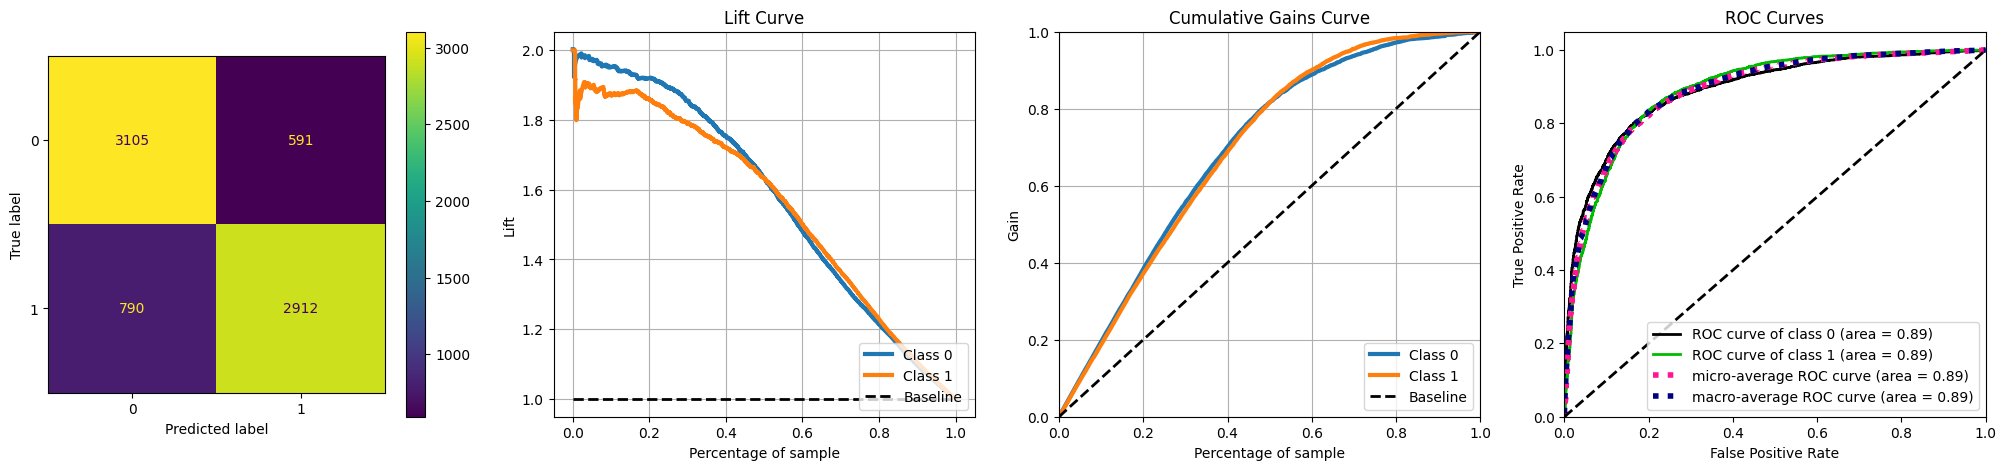

In [68]:
# Pipeline do Modelo Regressão Logística
pipeline_regressao_logistica = pipeline.Pipeline(
                                                 [
                                                  ('EncodeVariaveis', pipeline_pre_processamento),
                                                  ('RegressaoLogistica', linear_model.LogisticRegression(random_state=42))     
                                                 ]
                                                )

# Treinamento do Modelo
pipeline_regressao_logistica.fit(X_treino, y_treino)

# Capacidade de Aprendizado
y_pred_reg_log_aprendizado = pipeline_regressao_logistica.predict(X_treino)
y_pred_prob_reg_log_aprendizado = pipeline_regressao_logistica.predict_proba(X_treino)

# Avaliação do aprendizado
acuracia_reg_log_aprendizado, precisao_reg_log_aprendizado, recuperacao_reg_log_aprendizado, auc_reg_log_aprendizado = metricas_avaliacao(y_treino, y_pred_reg_log_aprendizado, y_pred_prob_reg_log_aprendizado)


=============== Métricas Avaliação ==================
Acuracia: 81.46%.
Precisão: 82.49%.
Recuperação: 79.1%.
Auc: 89.31%.
===================== Matriz de Confusão =======================


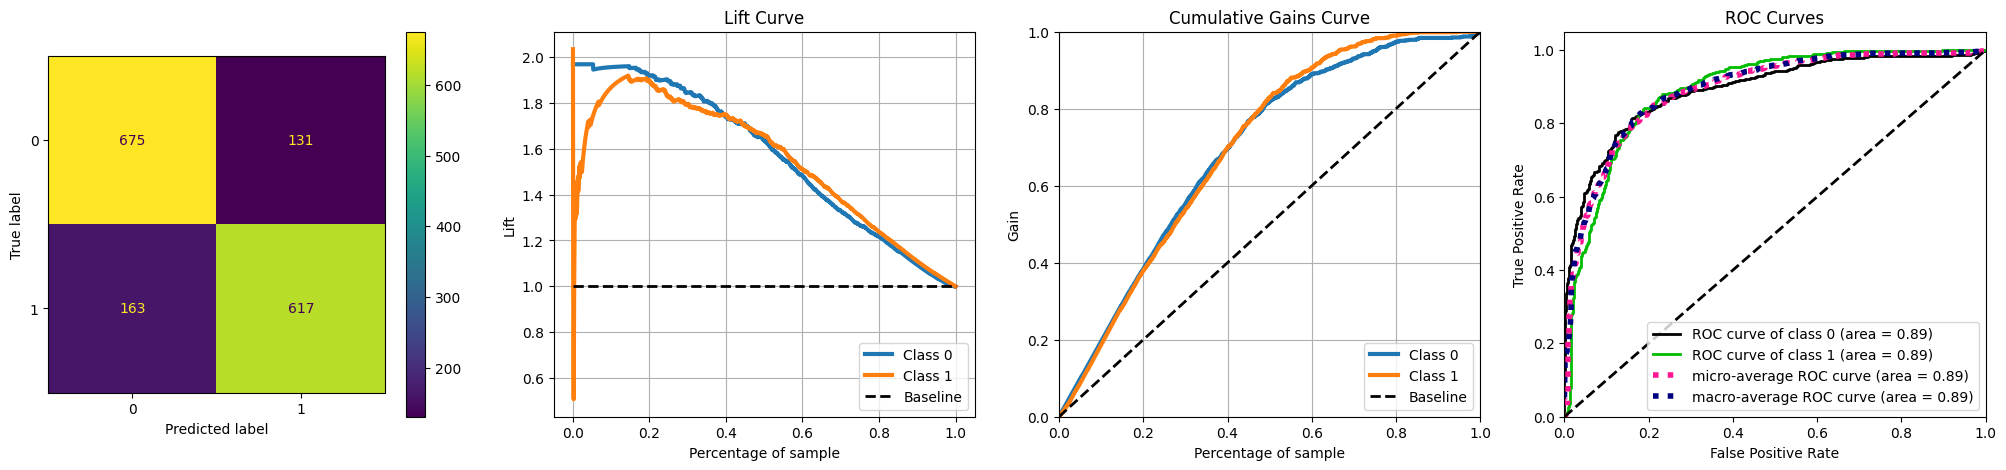

In [69]:
# Capacidade de Generalização
y_pred_reg_log_generalizacao = pipeline_regressao_logistica.predict(X_validacao)
y_pred_prob_reg_log_generalizacao = pipeline_regressao_logistica.predict_proba(X_validacao)

# Avaliação
acuracia_reg_log_generalizacao, precisao_reg_log_generalizacao, recuperacao_reg_log_generalizacao, auc_reg_log_generalizacao = metricas_avaliacao(y_validacao, y_pred_reg_log_generalizacao, y_pred_prob_reg_log_generalizacao)

### 8.2 Decision Tree

=============== Métricas Avaliação ==================
Acuracia: 80.14%.
Precisão: 81.28%.
Recuperação: 78.36%.
Auc: 87.78%.
===================== Matriz de Confusão =======================


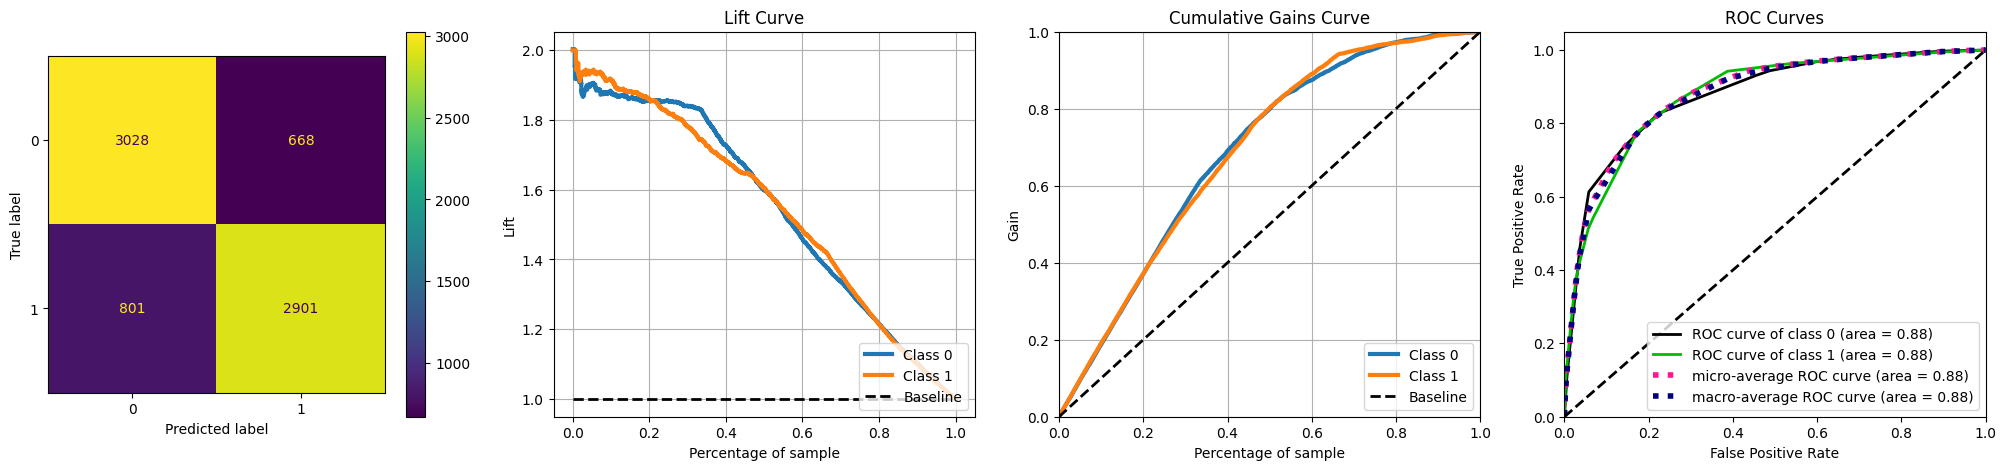

In [70]:
# Pipeline do Modelo Regressão Logística
pipeline_decision_tree = pipeline.Pipeline([('EncodeVariaveis', pipeline_pre_processamento),('Decision Tree', tree.DecisionTreeClassifier(max_depth=5, random_state=42))])

# Treinamento do Modelo
pipeline_decision_tree.fit(X_treino, y_treino)

# Capacidade de Aprendizado
y_pred_decision_tree_aprendizado = pipeline_decision_tree.predict(X_treino)
y_pred_prob_decision_tree_aprendizado = pipeline_decision_tree.predict_proba(X_treino)

# Avaliação do aprendizado
acuracia_decision_tree_aprendizado, precisao_decision_tree_aprendizado, recuperacao_decision_tree_aprendizado, auc_decision_tree_aprendizado = metricas_avaliacao(y_treino, y_pred_decision_tree_aprendizado, y_pred_prob_decision_tree_aprendizado)


=============== Métricas Avaliação ==================
Acuracia: 77.87%.
Precisão: 78.71%.
Recuperação: 75.38%.
Auc: 85.27%.
===================== Matriz de Confusão =======================


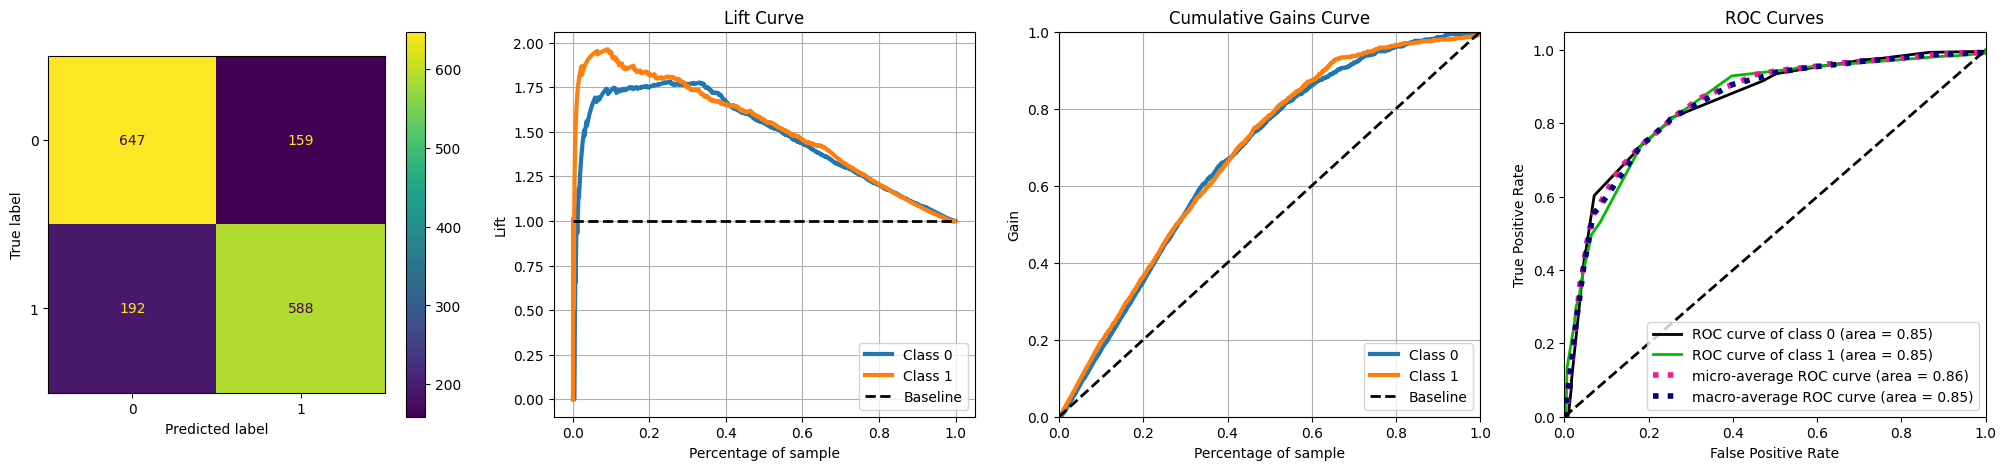

In [71]:
# Capacidade de Generalização
y_pred_decision_tree_generalizacao = pipeline_decision_tree.predict(X_validacao)
y_pred_prob_decision_tree_generalizacao = pipeline_decision_tree.predict_proba(X_validacao)

# Avaliação
acuracia_decision_tree_generalizacao, precisao_decision_tree_generalizacao, recuperacao_decision_tree_generalizacao, auc_decision_tree_generalizacao = metricas_avaliacao(y_validacao, y_pred_decision_tree_generalizacao, y_pred_prob_decision_tree_generalizacao)

### 8.3 KNN

=============== Métricas Avaliação ==================
Acuracia: 84.48%.
Precisão: 84.27%.
Recuperação: 84.82%.
Auc: 92.78%.
===================== Matriz de Confusão =======================


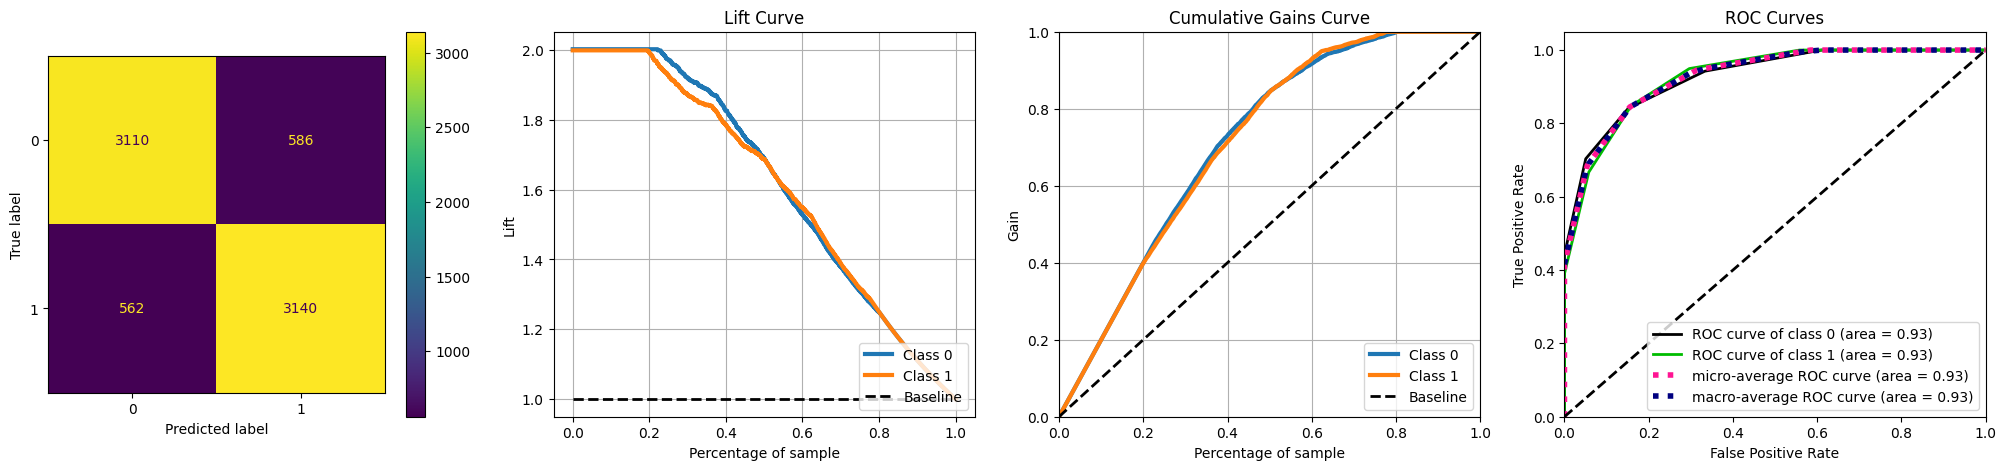

In [72]:
# Pipeline do Modelo Regressão Logística
pipeline_knn = pipeline.Pipeline([('EncodeVariaveis', pipeline_pre_processamento),('Decision Tree', neighbors.KNeighborsClassifier(n_neighbors=5, n_jobs=-1))])

# Treinamento do Modelo
pipeline_knn.fit(X_treino, y_treino)

# Capacidade de Aprendizado
y_pred_knn_aprendizado = pipeline_knn.predict(X_treino)
y_pred_prob_knn_aprendizado = pipeline_knn.predict_proba(X_treino)

# Avaliação do aprendizado
acuracia_knn_aprendizado, precisao_knn_aprendizado, recuperacao_knn_aprendizado, auc_knn_aprendizado = metricas_avaliacao(y_treino, y_pred_knn_aprendizado, y_pred_prob_knn_aprendizado)

=============== Métricas Avaliação ==================
Acuracia: 78.88%.
Precisão: 78.27%.
Recuperação: 78.97%.
Auc: 85.01%.
===================== Matriz de Confusão =======================


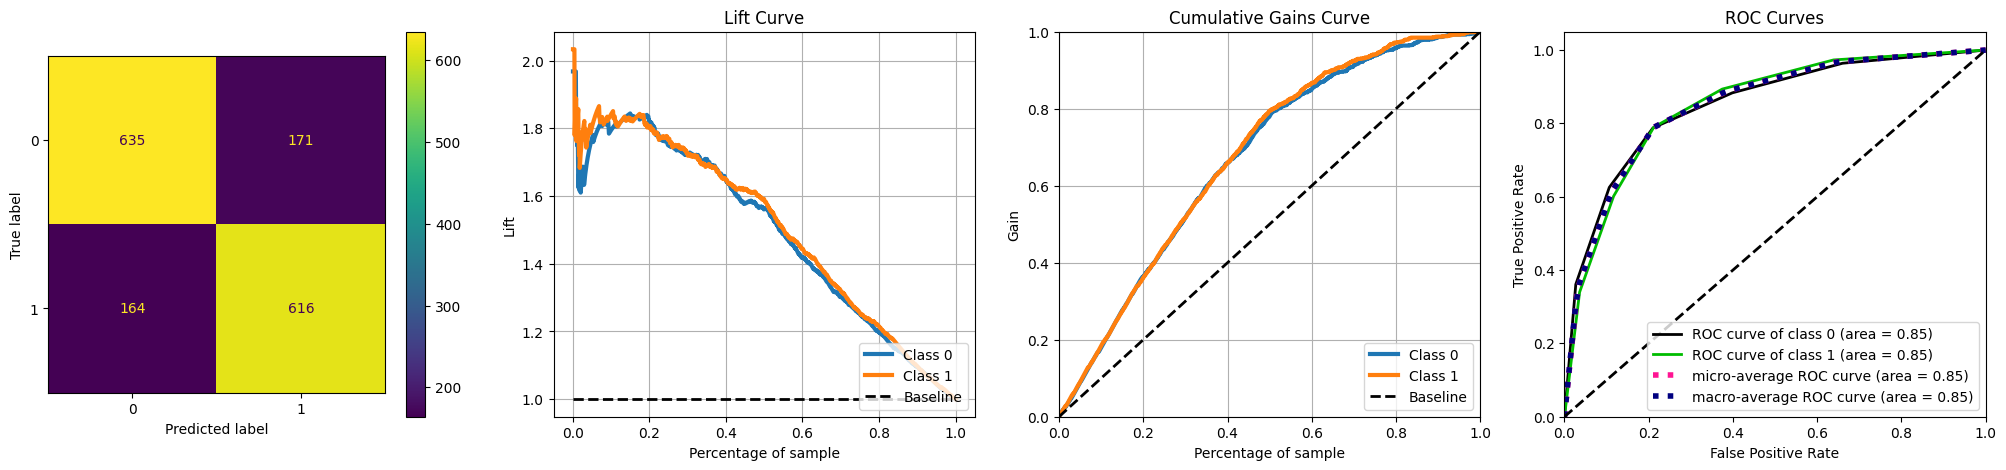

In [73]:
# Capacidade de Generalização
y_pred_knn_generalizacao = pipeline_knn.predict(X_validacao)
y_pred_prob_knn_generalizacao = pipeline_knn.predict_proba(X_validacao)

# Avaliação
acuracia_knn_generalizacao, precisao_knn_generalizacao, recuperacao_knn_generalizacao, auc_knn_generalizacao = metricas_avaliacao(y_validacao, y_pred_knn_generalizacao, y_pred_prob_knn_generalizacao)

**Avaliação Final**

In [ ]:
# Métricas de Aprendizado
precisao_aprendizado = [precisao_reg_log_aprendizado,
                        precisao_decision_tree_aprendizado,
                        precisao_knn_aprendizado]

recuperacao_aprendizado = [recuperacao_reg_log_aprendizado,
                           recuperacao_decision_tree_aprendizado,
                           recuperacao_knn_aprendizado]

auc_aprendizado = [auc_reg_log_aprendizado,
                   auc_decision_tree_aprendizado,
                   auc_knn_aprendizado]
''
acuracia_aprendizado = [acuracia_reg_log_aprendizado,
                        acuracia_decision_tree_aprendizado,
                        acuracia_knn_aprendizado]

pd.DataFrame([acuracia_aprendizado, precisao_aprendizado, recuperacao_aprendizado, auc_aprendizado], 
             columns=['Regressão Logística', 'Decision Tree', 'KNN'], 
             index=['Acurácia', 'Precisão', 'Recuperação', 'AUC'])

,Regressão Logística,Decision Tree,KNN
Acurácia,0.813328,0.801433,0.844823
Precisão,0.831287,0.812833,0.842727
Recuperação,0.786602,0.783630,0.848190
AUC,0.890496,0.877811,0.927765


In [75]:
# Métricas de Generalização
precisao_generalizacao = [precisao_reg_log_generalizacao,
                        precisao_decision_tree_generalizacao,
                        precisao_knn_generalizacao]

recuperacao_generalizacao = [recuperacao_reg_log_generalizacao,
                           recuperacao_decision_tree_generalizacao,
                           recuperacao_knn_generalizacao]

auc_generalizacao = [auc_reg_log_generalizacao,
                   auc_decision_tree_generalizacao,
                   auc_knn_generalizacao]

acuracia_generalizacao = [acuracia_reg_log_generalizacao,
                        acuracia_decision_tree_generalizacao,
                        acuracia_knn_generalizacao]

pd.DataFrame([acuracia_generalizacao, precisao_generalizacao, recuperacao_generalizacao, auc_generalizacao], 
             columns=['Regressão Logística', 'Decision Tree', 'KNN'], 
             index=['Acurácia', 'Precisão', 'Recuperação', 'AUC'])

,Regressão Logística,Decision Tree,KNN
Acurácia,0.814628,0.778689,0.788777
Precisão,0.824866,0.787149,0.782719
Recuperação,0.791026,0.753846,0.789744
AUC,0.893140,0.852734,0.850130


Quando analisamos a capacidade de aprendizado, o KNN foi o modelo que performou melhor. Em contrapartida, a regressão logística e a decision tree se manteram mais performáticas e estáveis. Por questões de complexidade, vamos optar pela regressão logística.

## 9.0 Validação Cruzada

Na nossa validação cruzada, nosso objetivo é entender se o modelo é, de fato, bem performático, independente do frame do dataset. Sendo assim, vamos juntar os dados de treino e validação e realizar esse teste.

In [76]:
# Variáveis independentes
X_validacao_cruzada = pd.concat([X_treino, X_validacao], axis=0)

# Variável alvo
y_validacao_cruzada = pd.concat([y_treino, y_validacao], axis=0)

# Construção da validação cruzada
roc_auc_cross = model_selection.cross_validate(pipeline_regressao_logistica, X_validacao_cruzada, y_validacao_cruzada, cv=5, scoring=['roc_auc'])
precision_cross = model_selection.cross_validate(pipeline_regressao_logistica, X_validacao_cruzada, y_validacao_cruzada, cv=5, scoring=['precision'])
recall_cross = model_selection.cross_validate(pipeline_regressao_logistica, X_validacao_cruzada, y_validacao_cruzada, cv=5, scoring=['recall'])

In [77]:
print(f'AUC -> Média: {np.round(np.mean(roc_auc_cross['test_roc_auc']), 2)*100}%; Desvio de Padrão: {np.round(np.std(roc_auc_cross['test_roc_auc']), 4)*100}')
print(f'Precisão -> Média: {np.round(np.mean(precision_cross['test_precision']), 2)*100}%; Desvio de Padrão: {np.round(np.std(precision_cross['test_precision']), 4)*100}')
print(f'Recuperação -> Média: {np.round(np.mean(recall_cross['test_recall']), 2)*100}%; Desvio de Padrão: {np.round(np.std(recall_cross['test_recall']), 4)*100}')

AUC -> Média: 89.0%; Desvio de Padrão: 0.41000000000000003
Precisão -> Média: 83.0%; Desvio de Padrão: 0.91
Recuperação -> Média: 79.0%; Desvio de Padrão: 0.27


Nosso modelo se mostrou relativamente estável. Sendo assim, vamos seguir com a regressão logística.

## 10.0 Otimização do Threshold

Nessa etapa, após verificar que o nosso modelo escolhido é a regressão logística, começamos, agora, as etapas de refino. Primeiramente, temos a hiperparametrização. Isto é, vamos refinar o modelo.

In [78]:
# Tunning do melhor corte
pipeline_regressao_logistica_threshold_tunned = model_selection.TunedThresholdClassifierCV(pipeline_regressao_logistica, cv=5, response_method='predict_proba', thresholds=200, random_state=42, scoring='roc_auc').fit(X_validacao_cruzada, y_validacao_cruzada)

# Verificação do melhor threshold
pipeline_regressao_logistica_threshold_tunned.best_threshold_

np.float64(0.44770585222093184)

=============== Métricas Avaliação ==================
Acuracia: 80.9%.
Precisão: 80.79%.
Recuperação: 81.69%.
Auc: 88.88%.
===================== Matriz de Confusão =======================


(0.808953341740227, 0.8078817733990148, 0.8169364881693649, 0.8887536998070771)

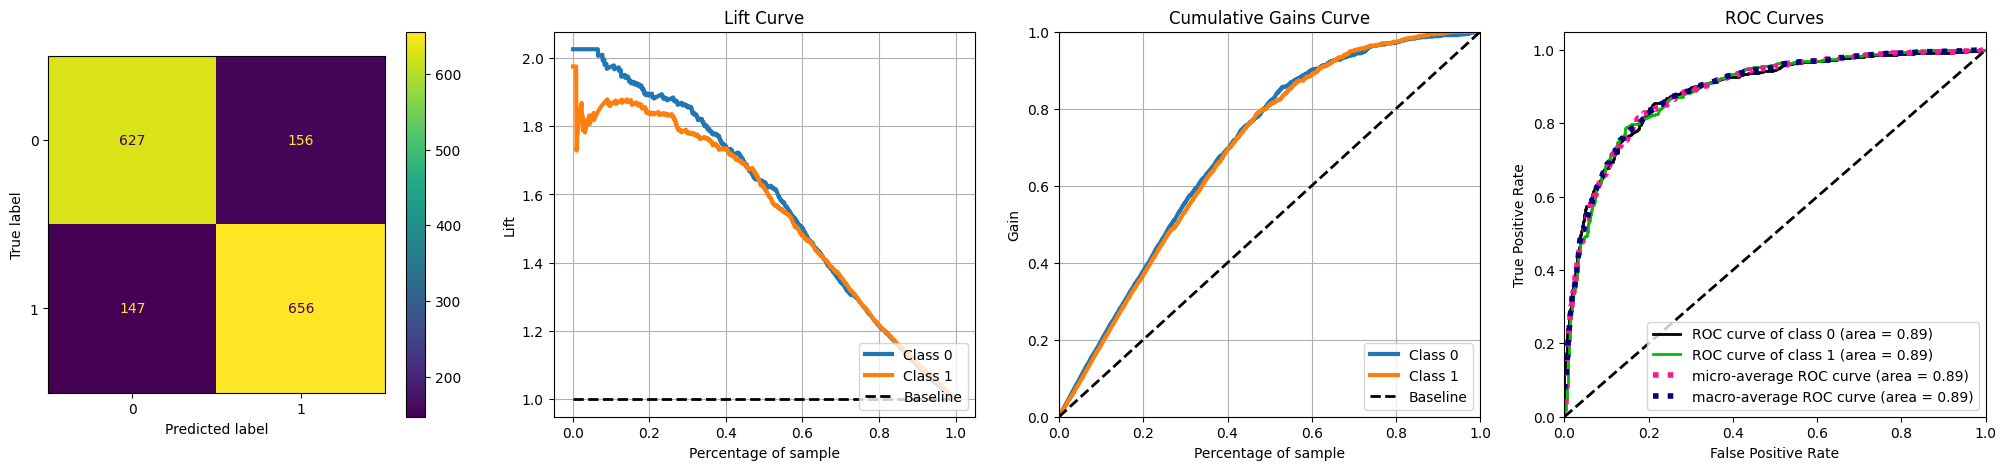

In [79]:
# Predições
y_predict_threshold_tunned = pipeline_regressao_logistica_threshold_tunned.predict(X_teste)
y_predict_proba_threshold_tunned = pipeline_regressao_logistica_threshold_tunned.predict_proba(X_teste)

# Avaliação
metricas_avaliacao(y_teste, y_predict_threshold_tunned, y_predict_proba_threshold_tunned)

## 11.0 Calibração da Probabilidade

Com a otimização do nosso threshold, vamos agora, ajustar as probabilidades do modelos. Isso é extremamente importante, pois podemos ter um modelo superconfiante, isto é, por exemplo, um cliente possui 60% de probabilidade, mas o modelo o classifica com 90%.

**Modelo antes da Calibração**

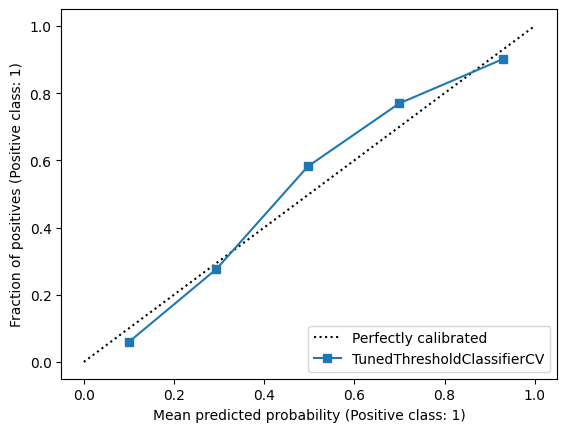

In [80]:
# Plotagem das informações
disp = calibration.CalibrationDisplay.from_estimator(pipeline_regressao_logistica_threshold_tunned, X_validacao_cruzada, y_validacao_cruzada)

# Display da imagem
plt.show()

**Calibragem do modelo com Isotonic**

In [81]:
# Calibração
pipeline_regressao_logistica_threshold_tunned_calibrated_isotonic = calibration.CalibratedClassifierCV(pipeline_regressao_logistica_threshold_tunned, cv=5, method='isotonic', ensemble=True)
pipeline_regressao_logistica_threshold_tunned_calibrated_isotonic.fit(X_validacao_cruzada, y_validacao_cruzada)

,estimator,TunedThreshol...hresholds=200)
,method,'isotonic'
,cv,5
,n_jobs,None
,ensemble,True
,steps,"[('EncodeVariaveis', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('age', ...), ('job', ...), ...]"
,remainder,'drop'


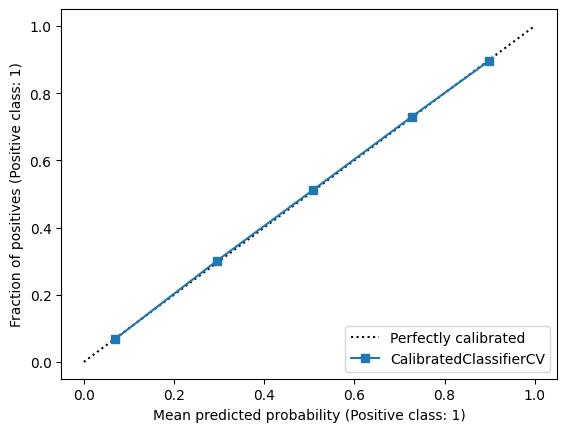

In [82]:
# Plotagem das informações
disp = calibration.CalibrationDisplay.from_estimator(pipeline_regressao_logistica_threshold_tunned_calibrated_isotonic, X_validacao_cruzada, y_validacao_cruzada)

# Display da imagem
plt.show()

## 12.0 Salvando o Modelo

Por fim, com um modelo bem calibrado, bem estável e com uma performance que atende bem as expectativas, vamos salvá-lo.


In [86]:
pkl.dump(pipeline_regressao_logistica_threshold_tunned_calibrated_isotonic, open('../ModeloProducao/ModeloAceitacaoContratoV1.pkl', 'wb'))